# Import

In [1]:
import pandas
import matplotlib
import scipy
import os
import collections
import itertools

%matplotlib inline

In [2]:
DATA_PATH = '../data/'
FIG_SIZE = 12,5
projects = sorted(os.listdir(DATA_PATH))
print(', '.join(projects))

dask, express, flask, gunicorn, lodash, luigi, moment, mypy, pelican, requests, sismic, tornado


In [3]:
dataframes = collections.OrderedDict()
for project in projects: 
    data = collections.OrderedDict()
    
    data['commits'] = pandas.read_csv(os.path.join(DATA_PATH, project, 'commits.csv'), 
                                      index_col='sha', 
                                      parse_dates=['author_date', 'committer_date']
                                     )
    data['commits'].rename(columns={'author_date': 'created_at', 'author': 'created_by'}, inplace=True)
    
    data['issues'] = pandas.read_csv(os.path.join(DATA_PATH, project, 'issues.csv'), 
                                     index_col='number', 
                                     parse_dates=['created_at', 'closed_at']
                                     )
    data['pulls'] = pandas.read_csv(os.path.join(DATA_PATH, project, 'pulls.csv'), 
                                    index_col='number', 
                                    parse_dates=['created_at', 'merged_at']
                                   )
    data['comments'] = pandas.read_csv(os.path.join(DATA_PATH, project, 'comments.csv'), 
                                       index_col='number', 
                                       parse_dates=['created_at']
                                      )
    dataframes[project] = data

In [4]:
data_types = ['commits', 'issues', 'pulls', 'comments']

def group_dataframe(dataframes, data_type):
    return pandas.concat(
        [dataframes[project][data_type].reset_index().assign(project=project).set_index(['project', dataframes[project][data_type].index.name]) for project in projects]
    )

In [5]:
df_commits = group_dataframe(dataframes, 'commits')
df_issues = group_dataframe(dataframes, 'issues')
df_pulls = group_dataframe(dataframes, 'pulls')
df_comments = group_dataframe(dataframes, 'comments')

# Description

## Visualisation

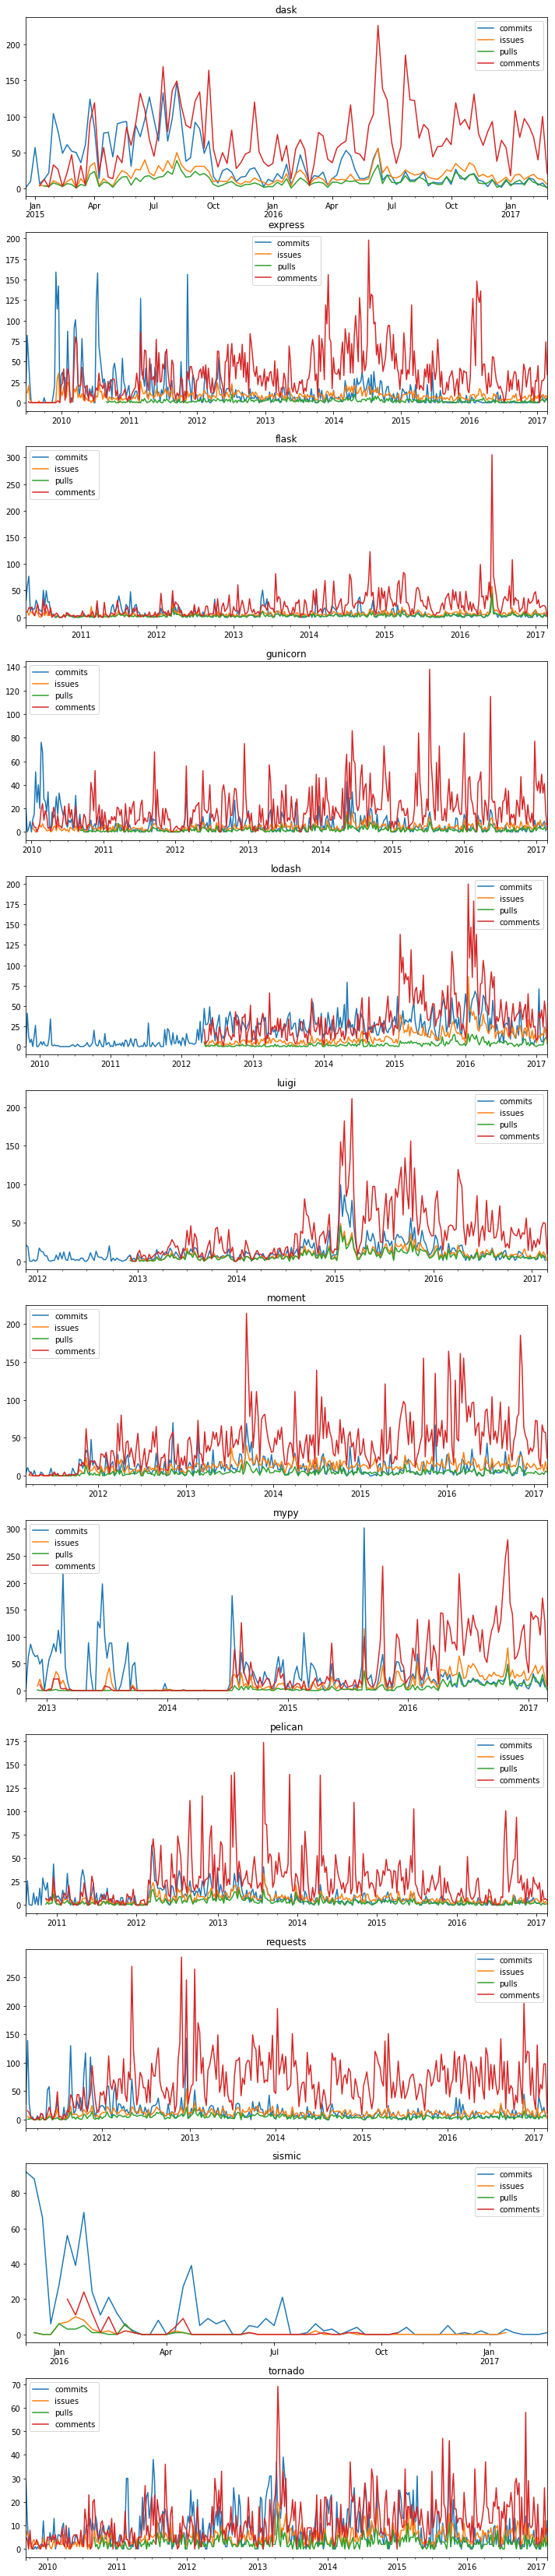

In [6]:
fig, axes = matplotlib.pyplot.subplots(nrows=len(projects))
fig.set_size_inches((FIG_SIZE[0], len(projects) * FIG_SIZE[1]))

for i, project in enumerate(projects): 
    ax = axes[i]
    for data_type in data_types:
        df = dataframes[project][data_type].assign(**{data_type: 1}).reset_index().set_index('created_at').resample('1W').count()[[data_type]]
        df.plot(ax=ax)
        ax.set_title(project)
        ax.set(xlabel='')

## Spectral analysis

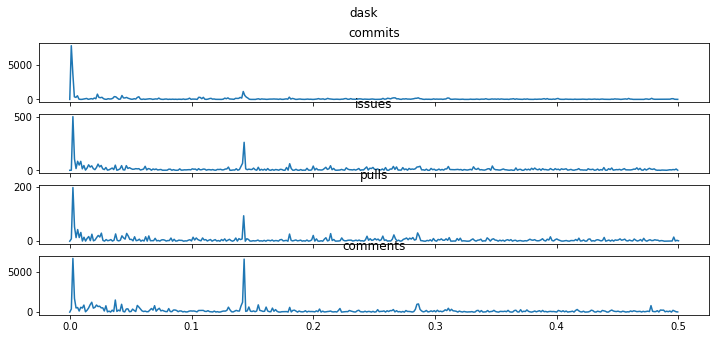

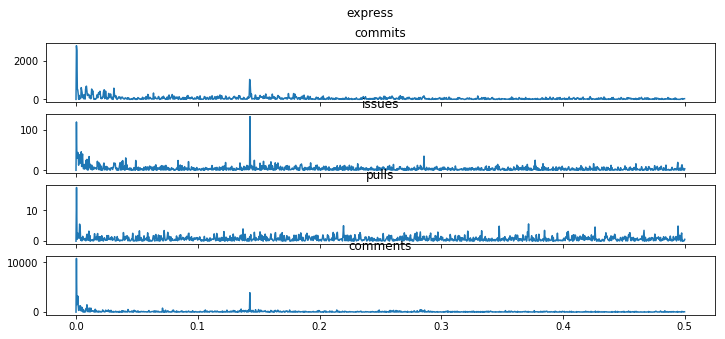

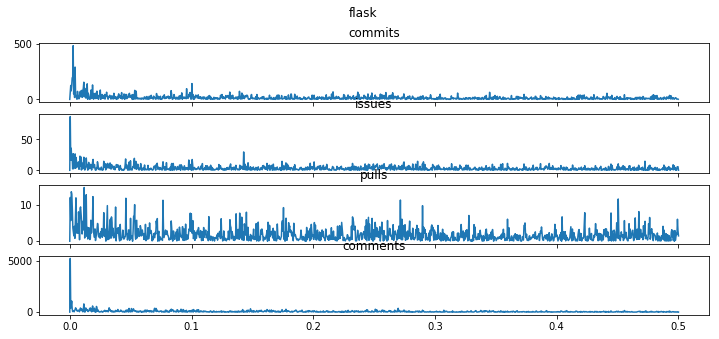

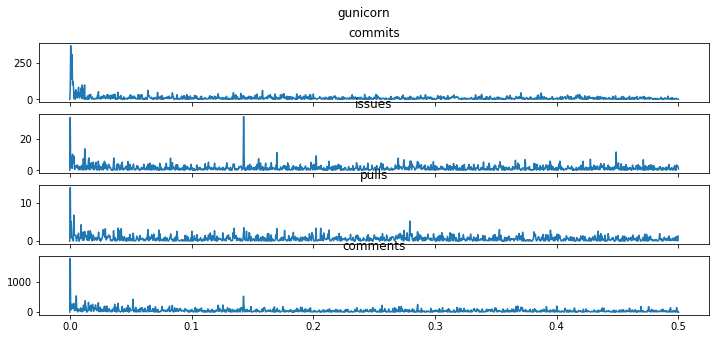

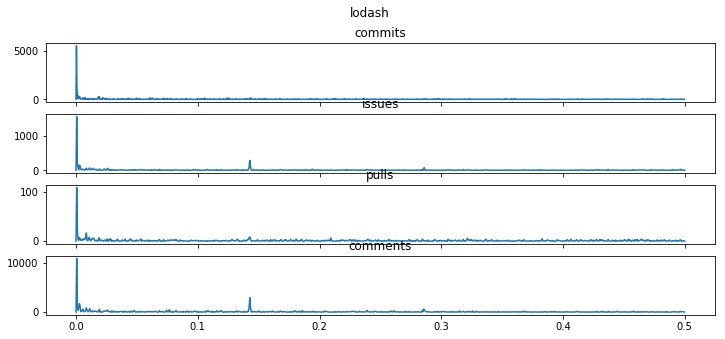

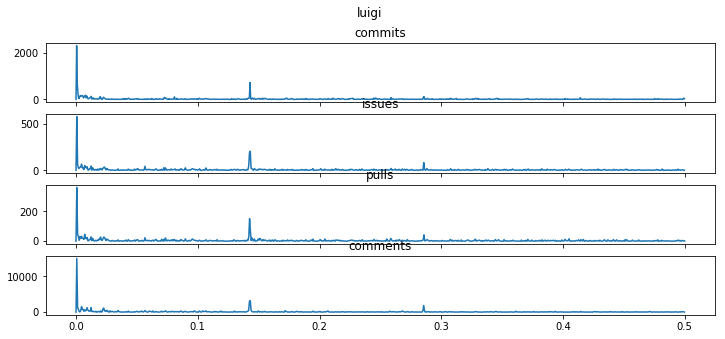

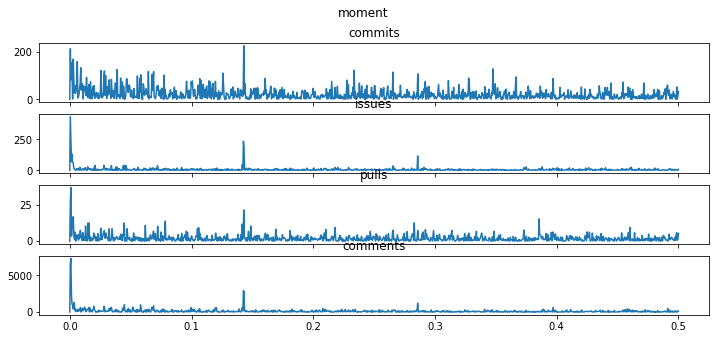

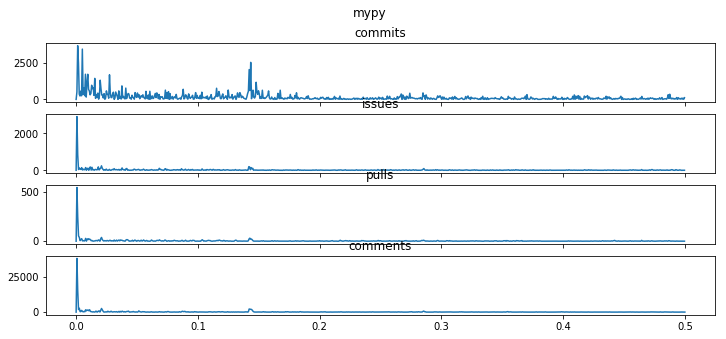

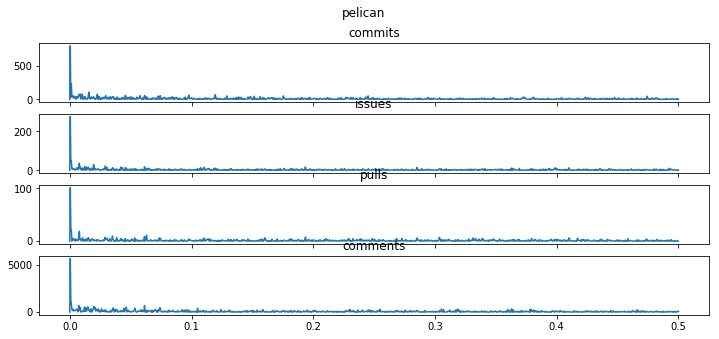

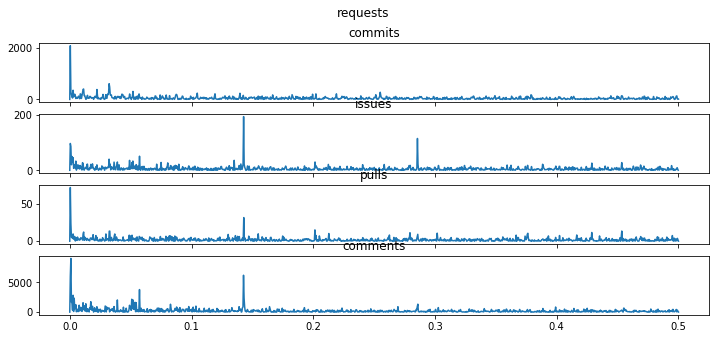

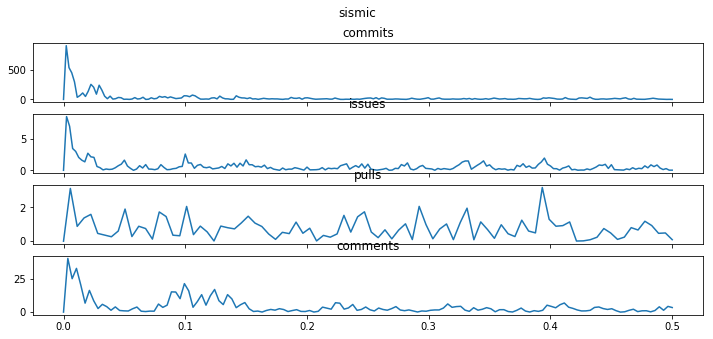

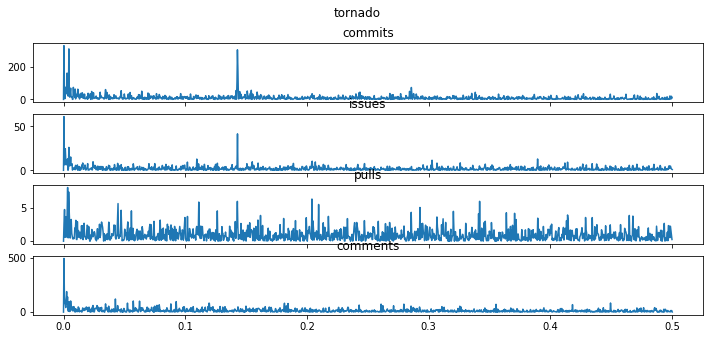

In [7]:
from scipy import signal

for i, project in enumerate(projects): 
    fig, axes = matplotlib.pyplot.subplots(nrows=len(data_types), sharex=True)
    fig.set_size_inches(FIG_SIZE)
    fig.suptitle(project)
    
    for j, data_type in enumerate(data_types):
        ax = axes[j]
        
        df = (dataframes[project][data_type]
              .assign(**{data_type: 1})
              .reset_index()
              .set_index('created_at')
              .resample('1D')
              .count()
              [data_type]
        )
        x, y = signal.periodogram(df)
        ax.plot(x, y)
        ax.set(
            title=data_type,
            xlabel='',
            yscale='linear',
        )

## Expanding mean

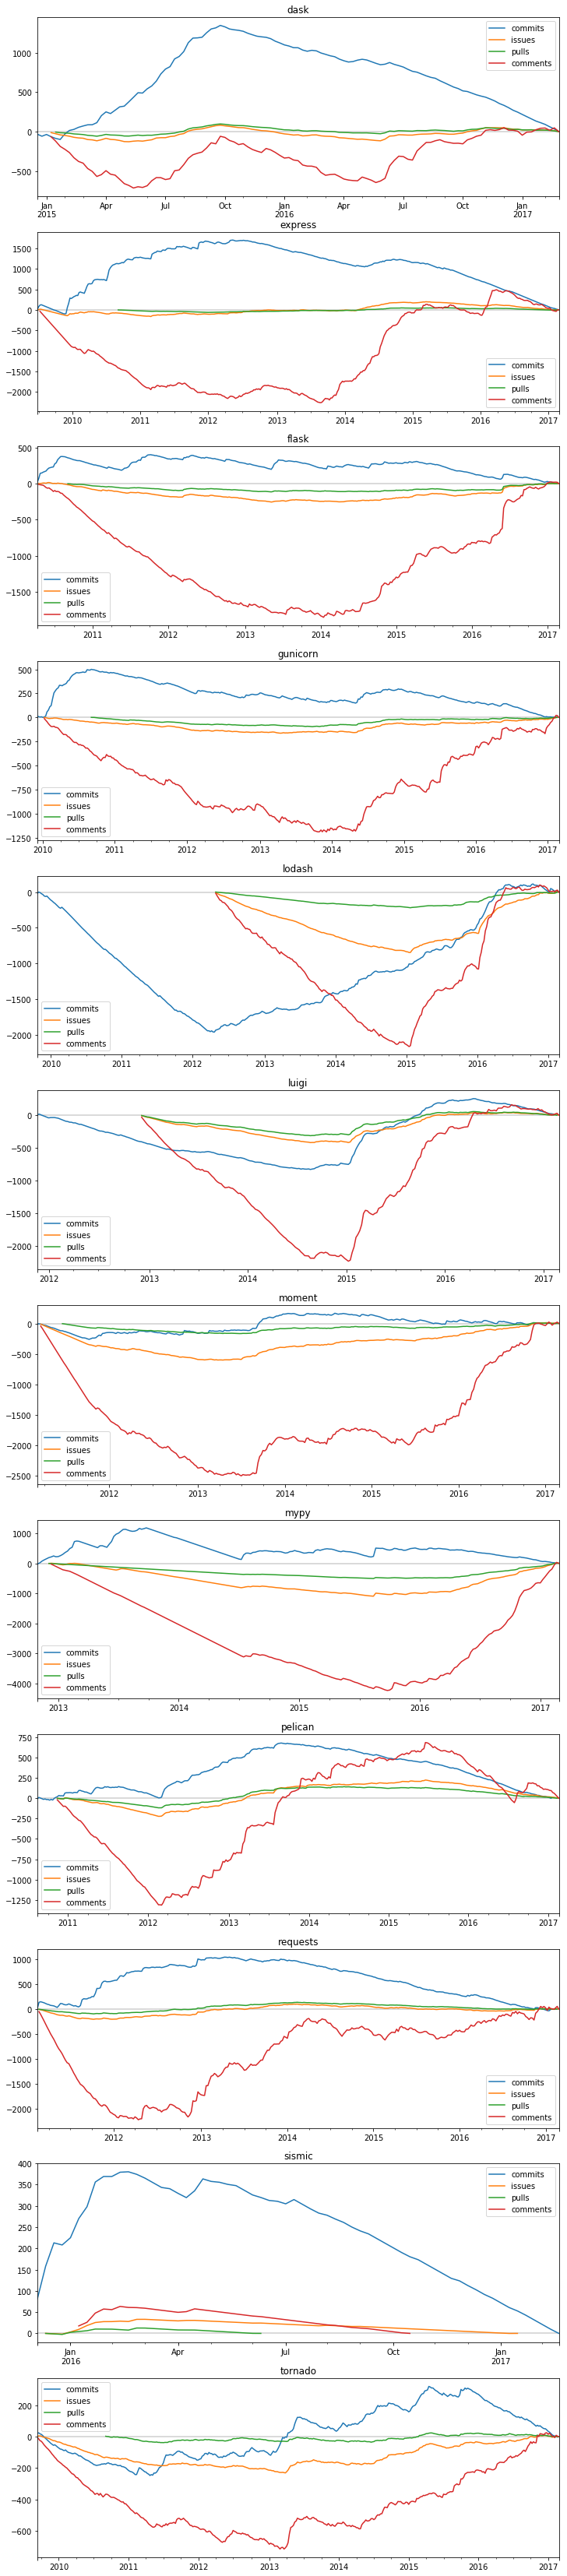

In [49]:
fig, axes = matplotlib.pyplot.subplots(nrows=len(projects))
fig.set_size_inches((FIG_SIZE[0], len(projects) * FIG_SIZE[1]))

for i, project in enumerate(projects): 
    ax = axes[i]
    for data_type in data_types:
        df = dataframes[project][data_type].assign(**{data_type: 1}).reset_index().set_index('created_at').resample('1W')[[data_type]].count()
        df = (df - df.mean()).cumsum()
        df.plot(ax=ax)
        ax.hlines(0, *ax.get_xlim(), colors='gray', alpha=0.1)
        ax.set_title(project)
        ax.set(xlabel='')